In [31]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
from navigation_mdp.plotting import *
from navigation_vis.Raster import Raster as NavGridView
# RL utils
import rl.planning as Plan
import rl.policy as Policy
# from rl.model import RewardLinear, RewardConvAE, RewardConvFCAE
from rl.model import ConvFCAutoEncoder, ConvAutoEncoder, RewardLinear
from irl.mlirl.mlirl import run_mlirl
# Utils
from utils.utils import *
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Satellite Image World

Note: image clipped to: (600, 800, 3)


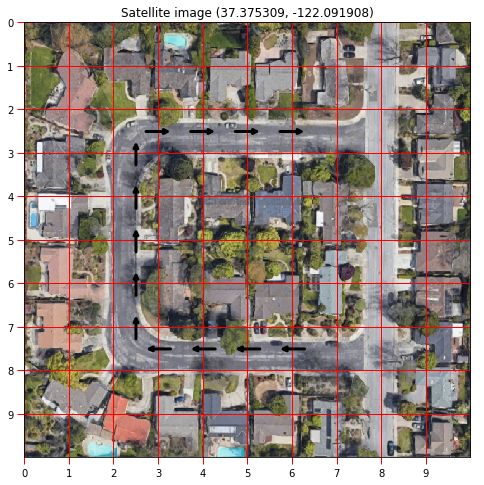

In [32]:
import cv2
img = cv2.imread("./Datasets/GoogleSatellite/goog_satimg_37.375309_-122.091908.png")[:,:,::-1]
img = cv2.resize(img, (800, 600))
# plt.imshow(img)
img_dtizer = NvMDP.features.ImageDiscretizer(img, 10, 10, (0,0))

# Expert demonstration
s_lst_lst = [[(7,6), (7,5), (7,4), (7,3), (7,2), 
              (6,2), (5,2), (4,2), (3,2), 
              (2,2), (2,3), (2,4), (2,5), (2,6)]]

plt.figure(figsize=(8,8))
NavGridView(img_dtizer() / 255.).render().ticks(minor=False).grid().add_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10}).title("Satellite image (37.375309, -122.091908)")

##  Setup LfD World

In [3]:
lfdw = NvMDP.world.DiscreteLfDWorld2D(
            discrete_state_space = NvMDP.state.DiscreteStateSpace(10,10),
            
            phi_spec = [],
            r_spec = [],
            class_ids = NvMDP.class_.XYClassDistribution(
                np.arange(10 * 10).reshape(10, 10).tolist())().flatten(),
    
            s_lst_lst = s_lst_lst,
            a_lst_lst = None
)

### Indicator features and linear reward

In [4]:
preprocess_fn_linear = lambda x: torch.FloatTensor(x)
postprocess_fn_linear = lambda x: x.squeeze()

lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIndicatorOneHot(key="state_ind"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model = RewardLinear(lfdw.get_feture_shape("state_ind"), lr=0.1, weight_decay=0.), 
        preprocess_fn = preprocess_fn_linear, 
        postprocess_fn = postprocess_fn_linear,
        key="state_ind_linear", feature_key="state_ind"))

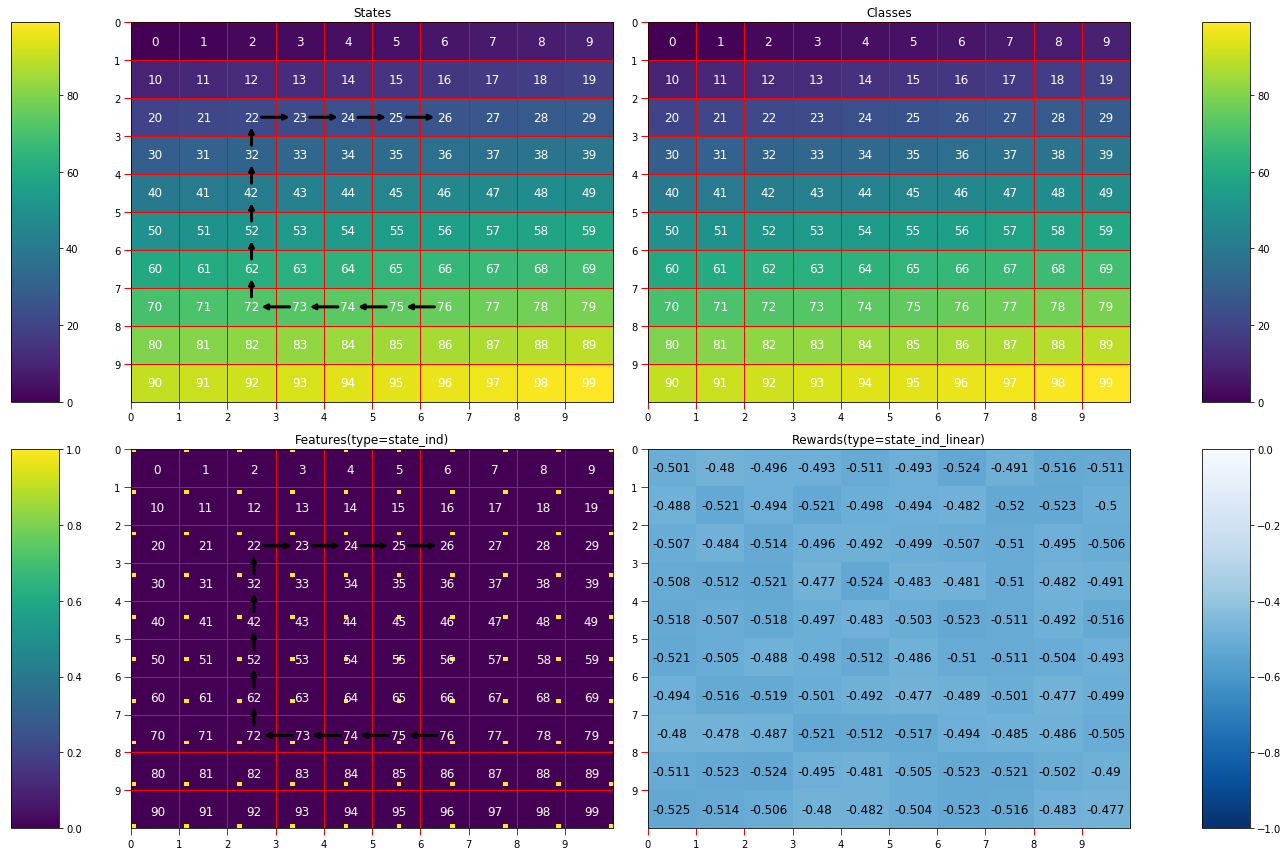

In [5]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="state_ind_linear", phi_key="state_ind", 
               v_range=[None, None, None, (0,-1)])

### Image features and CNN reward

In [6]:
preprocess_fn = lambda x: torch.FloatTensor(x).unsqueeze(0).permute(0,3,1,2) \
                                        if len(torch.FloatTensor(x).shape) == 3 \
                                        else torch.FloatTensor(x).permute(0,3,1,2)
postprocess_fn = lambda x: x.squeeze()
loc_to_array_fn = lambda row, col: img_dtizer.get_image_cell(row, col)/255.

r_model_cnn_fc = ConvFCAutoEncoder(
    preprocess_fn(loc_to_array_fn(0, 0)).shape[1:], z_dim=64, lr=0.005, weight_decay=0.)

# r_model_cnn = ConvAutoEncoder(
#     preprocess_fn(loc_to_array_fn(0, 0)).shape[1:], z_dim=64, lr=0.01, weight_decay=0.)

lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateLocToArray(loc_to_array_fn, key="rgb_image"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model = r_model_cnn_fc,
        preprocess_fn = preprocess_fn, 
        postprocess_fn = postprocess_fn,
        key="CNN", feature_key="rgb_image"))

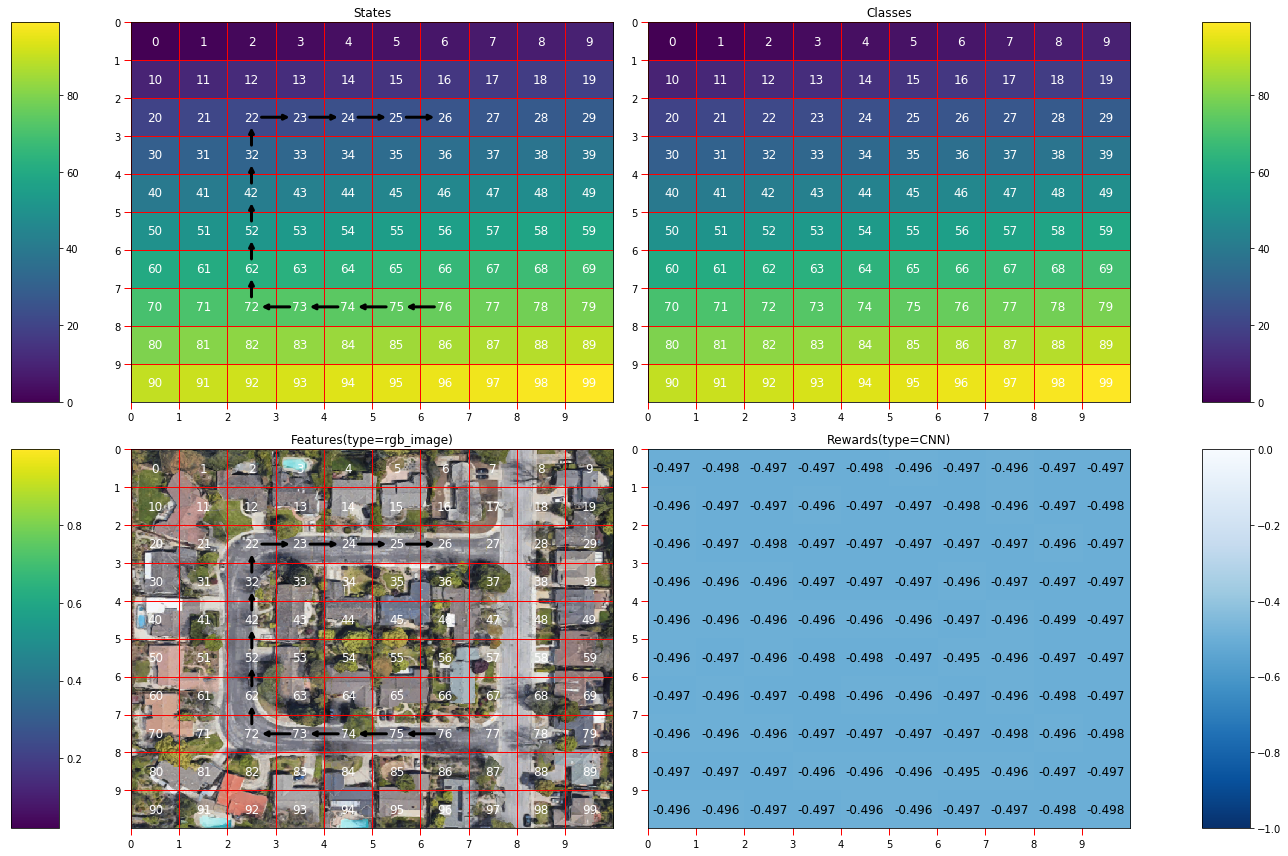

In [7]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="CNN", phi_key="rgb_image", 
               v_range=[None, None, None, (0,-1)])

### PCA features and linear reward

In [8]:
from sklearn.decomposition import PCA

pca_components = 10
PHI_flatten = lfdw.features(numpyize=True, key="rgb_image").reshape(len(lfdw.S), -1)
pca = PCA(n_components=pca_components)
pca.fit(PHI_flatten)
PHI_pca = pca.transform(PHI_flatten).reshape(len(lfdw.S), -1)

In [9]:
r_model_pca_linear = RewardLinear(pca_components, lr=0.1, weight_decay=0.)
lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIdxToArray(lambda idx: PHI_pca[idx], key="rgb_image_pca"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model_pca_linear, preprocess_fn=preprocess_fn_linear,
        postprocess_fn=postprocess_fn_linear, 
        key="pca_linear", feature_key="rgb_image_pca"))

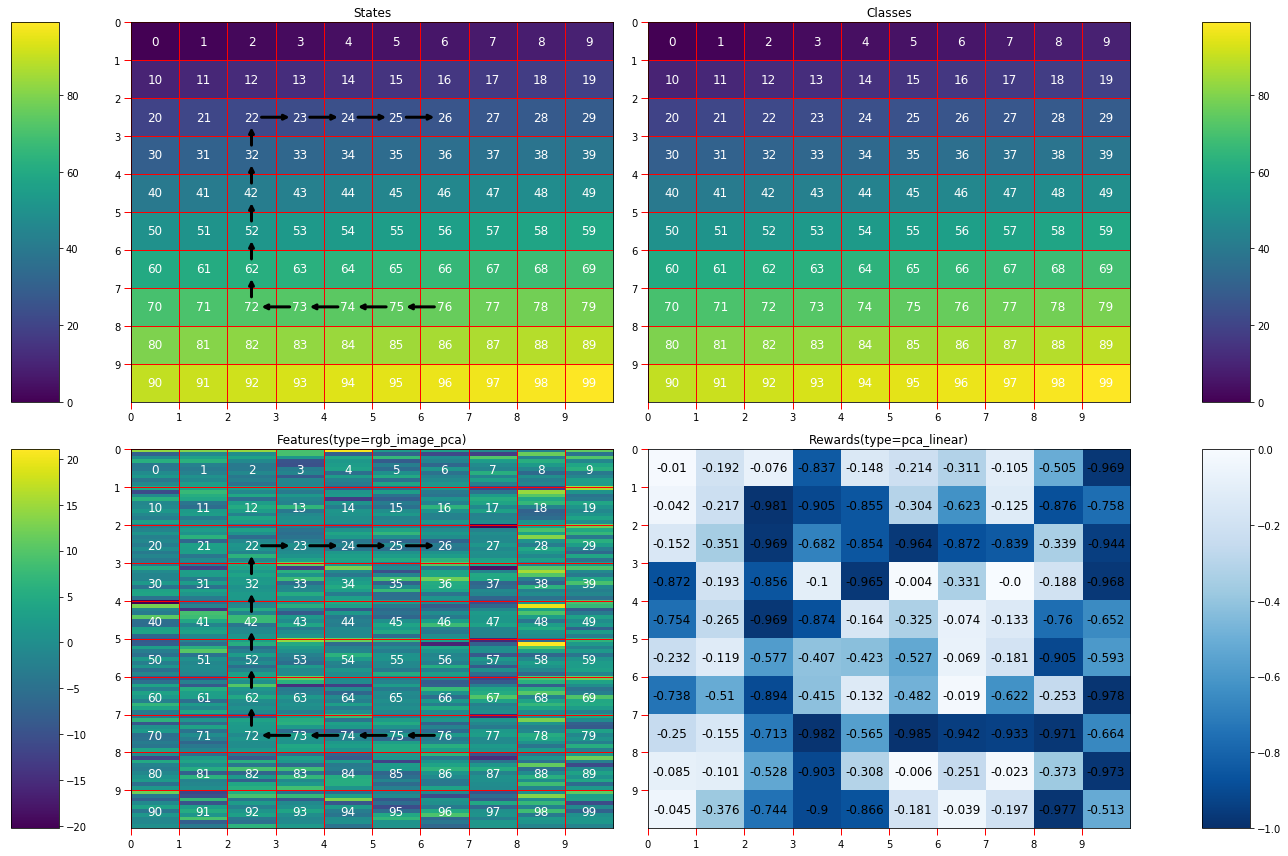

In [10]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="pca_linear", phi_key="rgb_image_pca",
              v_range=[None, None, None, (0,-1)])

### RGB + CNN with softmax value

In [12]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn(lfdw.features(numpyize=False, key="rgb_image")), 
    T = lfdw.dynamics(),
    R_model = r_model_cnn_fc,
    gamma=0.95,
    mlirl_iters = 100,
    vi_max_iters = 150,
    reasoning_iters = 50,
    policy = lambda q: Policy.Boltzmann(q, boltzmann_temp=0.1),
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Setting goal as terminal state!
Learning values [  0 ] Converged @ 18.
Reasoning [  18 48 67 ] Done (50 iters).
>>> Iter: 0000 (3.906s): loss = 33.822437, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 90.
Reasoning [  90 120 139 ] Done (50 iters).
>>> Iter: 0001 (5.968s): loss = 17.166700, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 27.
Reasoning [  27 57 76 ] Done (50 iters).
>>> Iter: 0002 (3.310s): loss = 13.807319, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 19.
Reasoning [  19 49 68 ] Done (50 iters).
>>> Iter: 0003 (3.084s): loss = 35.526829, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 23.
Reasoning [  23 53 72 ] Done (50 iters).
>>> Iter: 0004 (3.205s): loss = 11.798038, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 68.
Reasoning [  68 98 117 ] Done (50 

Running VI (goal: (2, 6))
Learning values [  0 30 ] Converged @ 56.
Reasoning [  56 86 105 ] Done (50 iters).
>>> Iter: 0047 (4.250s): loss = 00.683164, likelihood = 0.5050


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 99 ] Stopped @ 100.
Reasoning [  100 130 149 ] Done (50 iters).
>>> Iter: 0048 (5.694s): loss = 10.144418, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 99 ] Stopped @ 100.
Reasoning [  100 130 149 ] Done (50 iters).
>>> Iter: 0049 (5.650s): loss = 00.897136, likelihood = 0.4077


Running VI (goal: (2, 6))
Learning values [  0 30 ] Converged @ 43.
Reasoning [  43 73 92 ] Done (50 iters).
>>> Iter: 0050 (3.873s): loss = 01.898497, likelihood = 0.1498


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 61.
Reasoning [  61 91 110 ] Done (50 iters).
>>> Iter: 0051 (4.435s): loss = 02.243933, likelihood = 0.1060


Running VI (goal: (2, 6))
Learning values [  0 30 ] Converged @ 34.
Reasoning [  34 64 83 ] Done (50 it

Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 70.
Reasoning [  70 100 119 ] Done (50 iters).
>>> Iter: 0093 (4.703s): loss = 00.457095, likelihood = 0.6331


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 66.
Reasoning [  66 96 115 ] Done (50 iters).
>>> Iter: 0094 (4.584s): loss = 00.451176, likelihood = 0.6369


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 99 ] Stopped @ 100.
Reasoning [  100 130 149 ] Done (50 iters).
>>> Iter: 0095 (5.653s): loss = 00.427971, likelihood = 0.6518


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 61.
Reasoning [  61 91 110 ] Done (50 iters).
>>> Iter: 0096 (4.410s): loss = 00.390849, likelihood = 0.6765


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 99 ] Stopped @ 100.
Reasoning [  100 130 149 ] Done (50 iters).
>>> Iter: 0097 (5.658s): loss = 00.345400, likelihood = 0.7079


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 99 ] Stopped @ 100.
Reasoning [  100 13

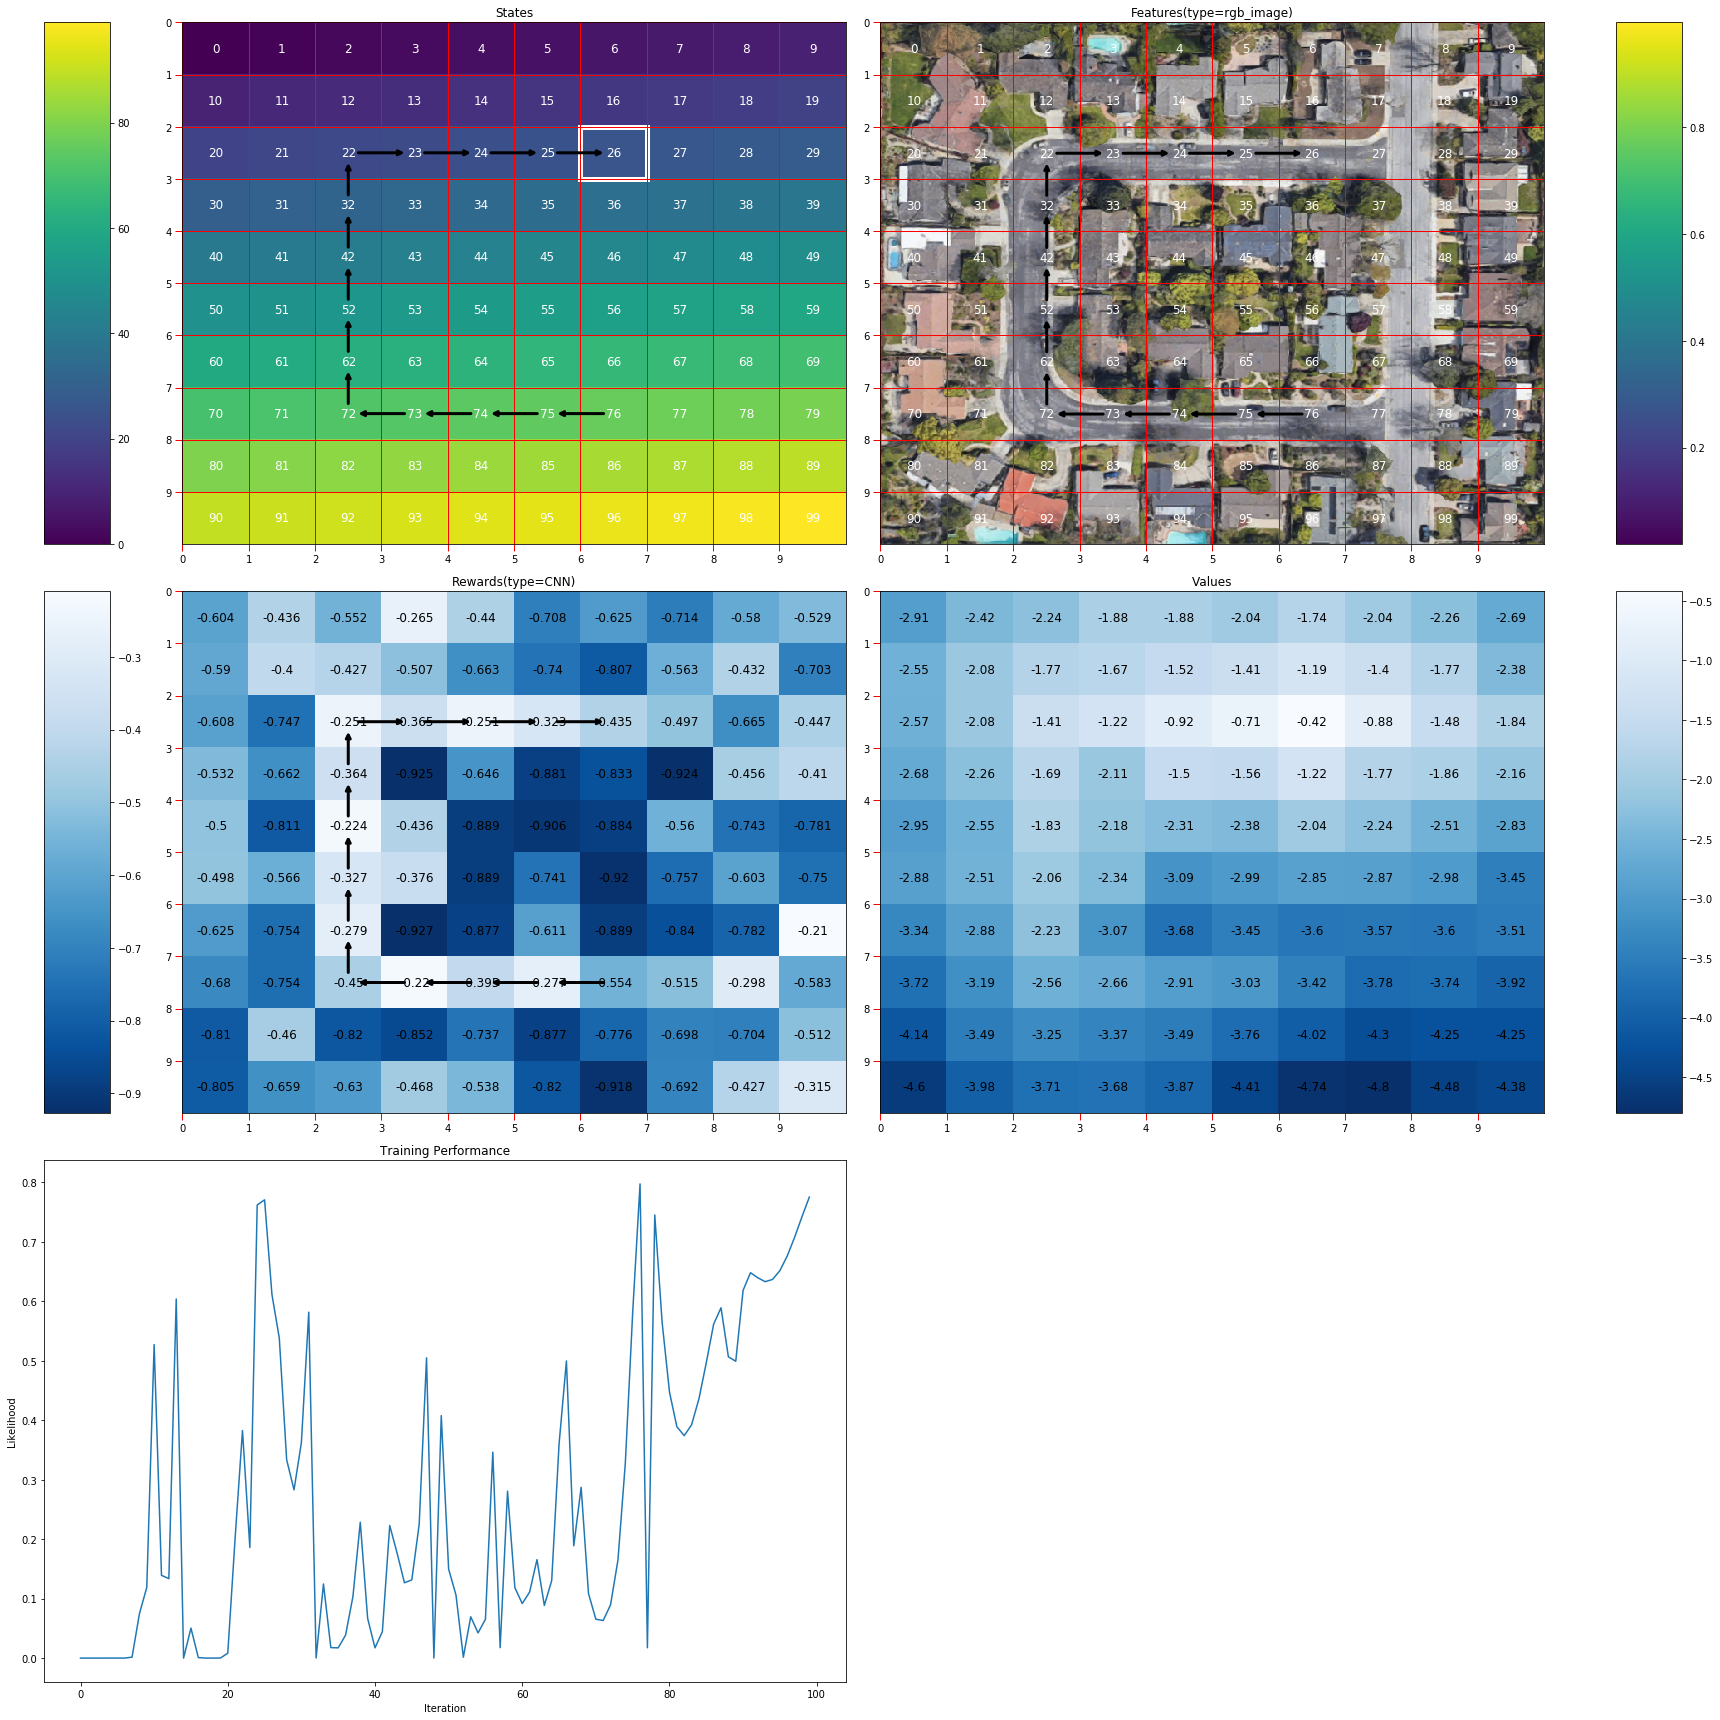

In [16]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="CNN", phi_key="rgb_image")
plt.savefig("./figures/mlirl_gridworld_10x10_cnn__traj_2_turns__temp_{}.png".format(boltzmann_temp))

In [19]:
r_model_cnn_fc.initialize() # TODO

In [20]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn(lfdw.features(numpyize=False, key="rgb_image")), 
    T = lfdw.dynamics(),
    R_model = r_model_cnn_fc,
    gamma=0.95,
    mlirl_iters = 100,
    vi_max_iters = 150,
    reasoning_iters = 50,
    policy = lambda q: Policy.Boltzmann(q, boltzmann_temp=0.01),
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 15.
Reasoning [  15 45 64 ] Done (50 iters).
>>> Iter: 0000 (2.924s): loss = 272.063385, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 21.
Reasoning [  21 51 70 ] Done (50 iters).
>>> Iter: 0001 (3.593s): loss = 18.018497, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0002 (2.602s): loss = 18.021828, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0003 (2.723s): loss = 18.021828, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0004 (2.656s): loss = 18.021828, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0005 (2.640s): loss = 18.021828, lik

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0097 (2.550s): loss = 18.021828, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0098 (2.531s): loss = 18.021828, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 1.
Reasoning [  1 31 50 ] Done (50 iters).
>>> Iter: 0099 (2.545s): loss = 18.021828, likelihood = 0.0000




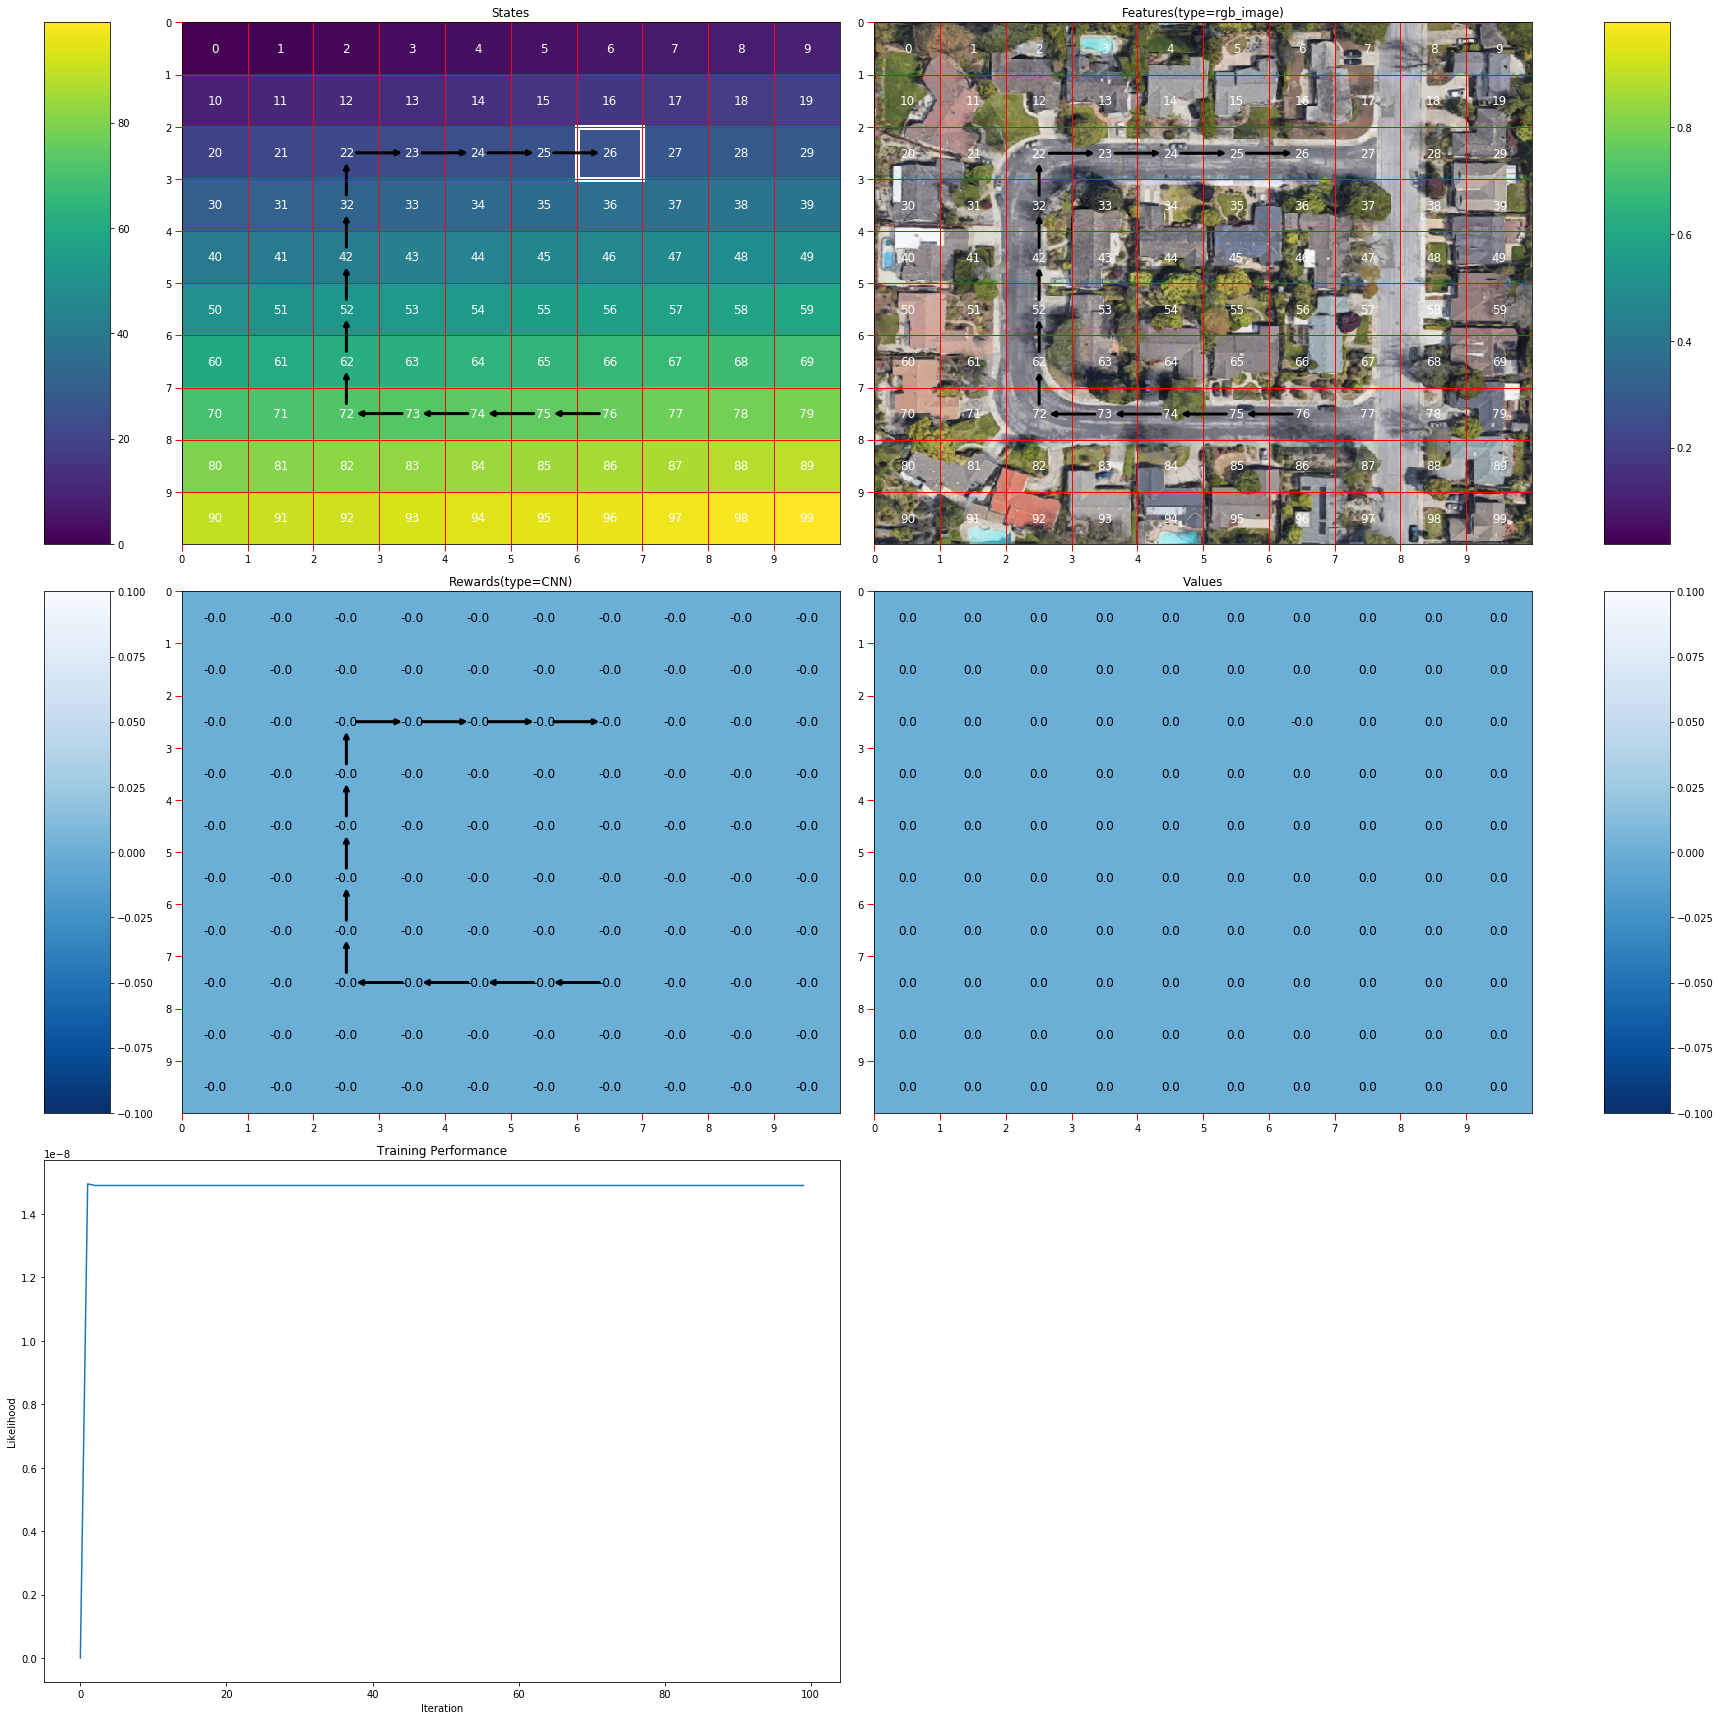

In [21]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="CNN", phi_key="rgb_image")
plt.savefig("./figures/mlirl_gridworld_10x10_cnn__traj_2_turns__temp_{}.png".format(boltzmann_temp))

## Ind + Linear

In [62]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn_linear(lfdw.features(numpyize=False, key="state_ind")),
    T = lfdw.dynamics(),
    R_model = lfdw.get_reward_model("state_ind_linear"),
    gamma=0.95,
    mlirl_iters = 100,
    vi_max_iters = 150,
    reasoning_iters = 50,
    policy=lambda q: Policy.Boltzmann(q, boltzmann_temp=0.01),
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 15.
Reasoning [  15 45 64 ] Done (50 iters).
>>> Iter: 0000 (2.784s): loss = 258.593842, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 14.
Reasoning [  14 44 63 ] Done (50 iters).
>>> Iter: 0001 (3.025s): loss = 224.421066, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 14.
Reasoning [  14 44 63 ] Done (50 iters).
>>> Iter: 0002 (2.973s): loss = 190.500443, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 13.
Reasoning [  13 43 62 ] Done (50 iters).
>>> Iter: 0003 (2.988s): loss = 157.991837, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 12.
Reasoning [  12 42 61 ] Done (50 iters).
>>> Iter: 0004 (2.875s): loss = 126.086105, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 12.
Reasoning [  12 42 61 ] Done (50 iters).
>>> Iter: 0005 (2.956s): loss = 95

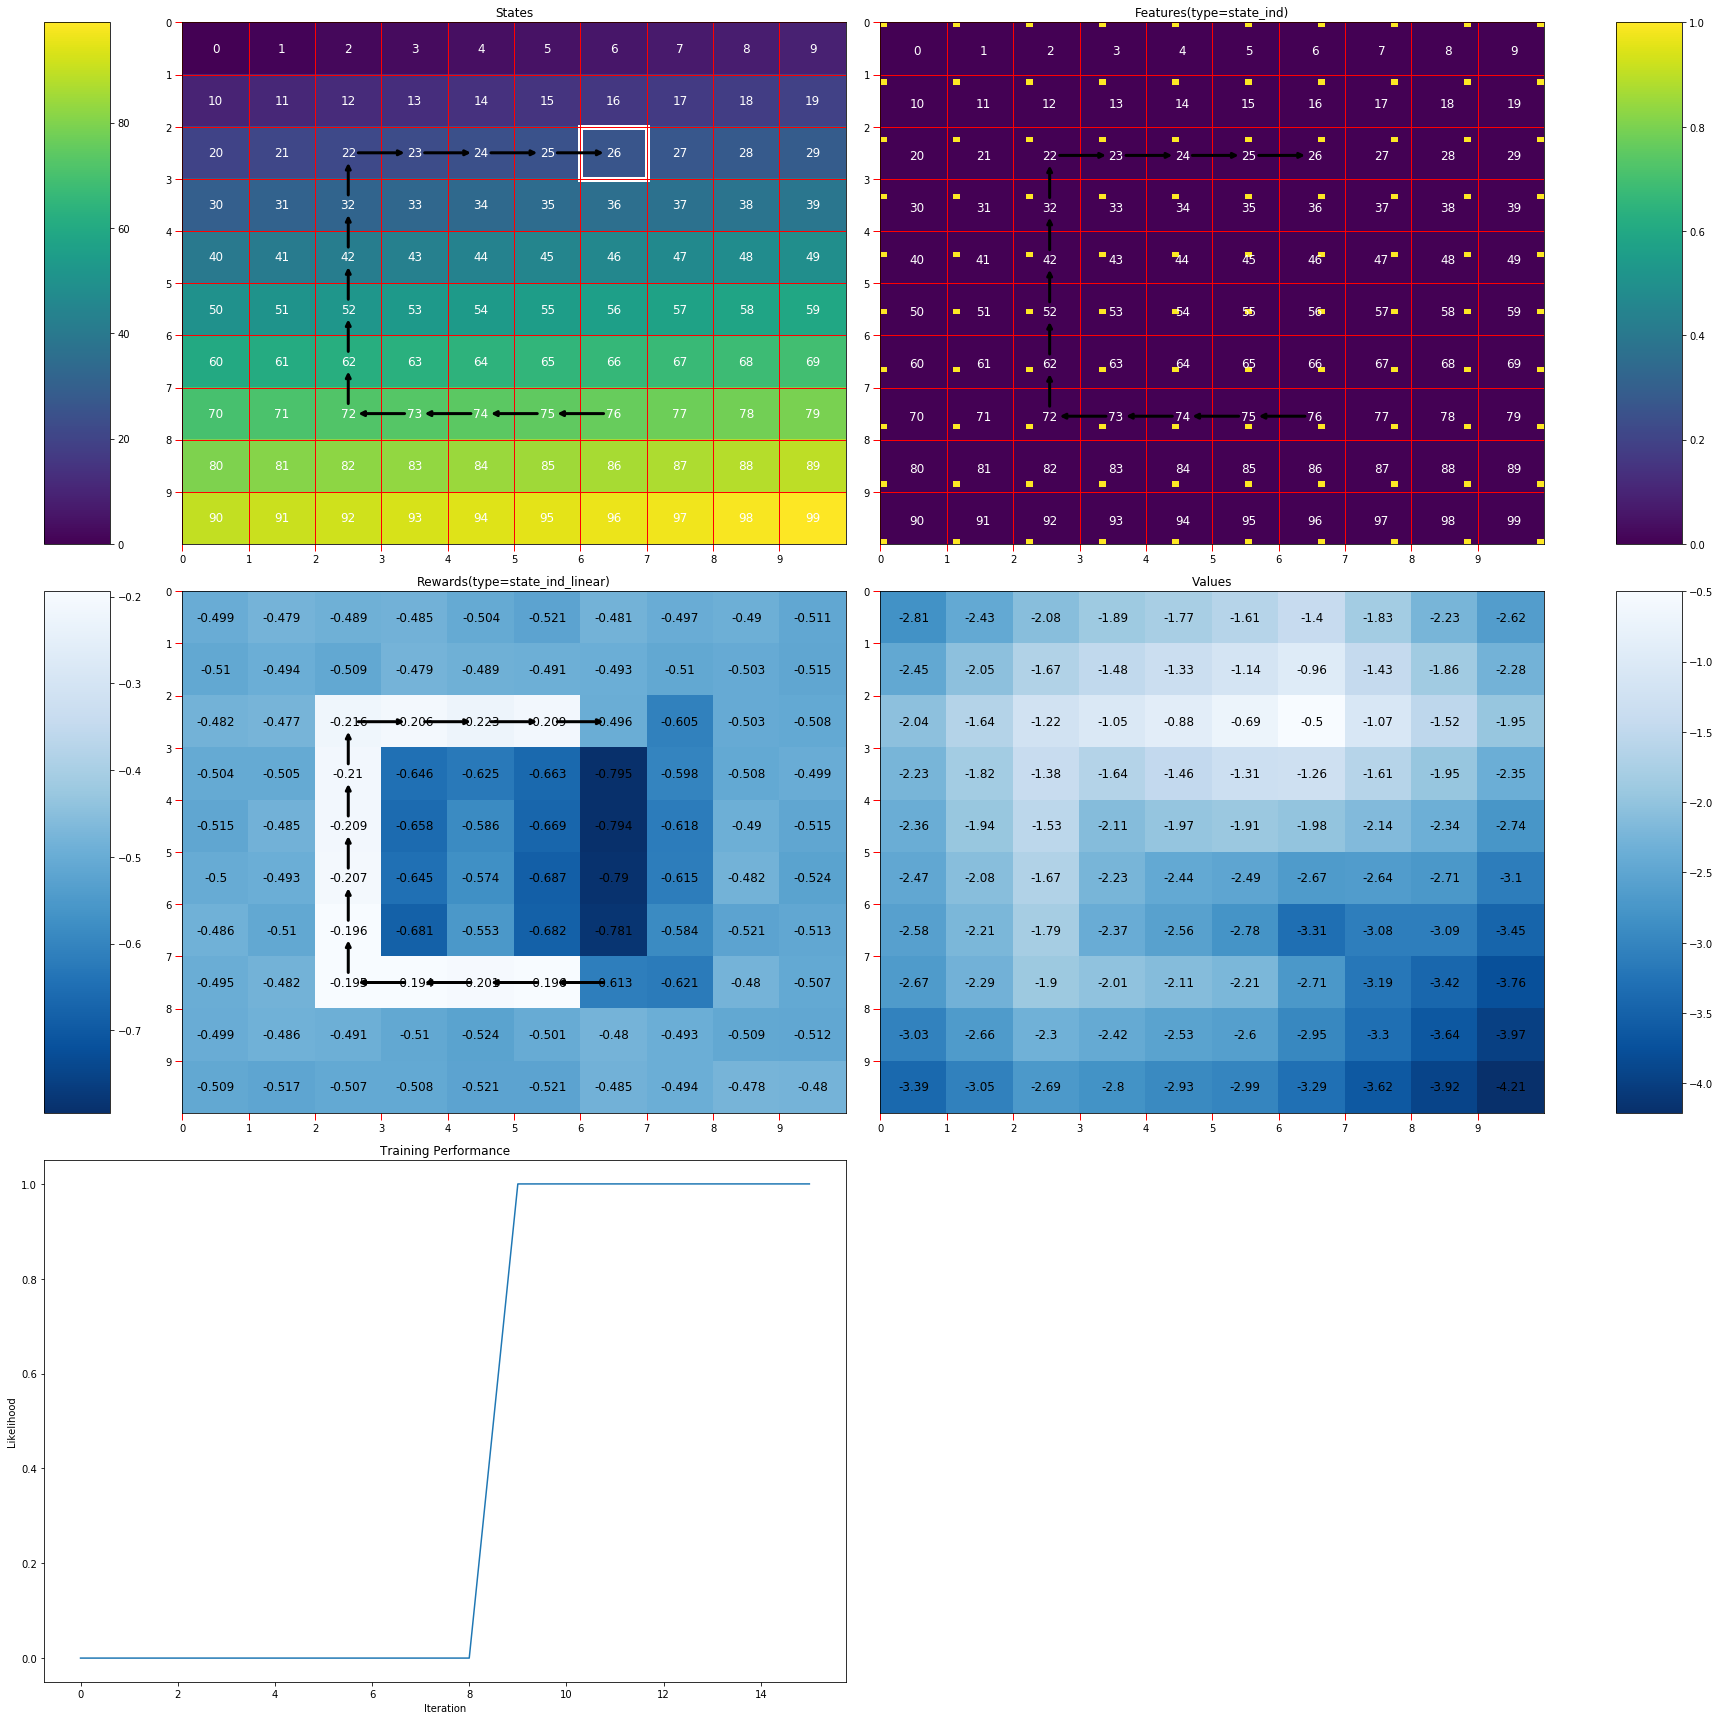

In [63]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="state_ind_linear", phi_key="state_ind")
plt.savefig("./figures/mlirl_gridworld_10x10_one_hot__traj_2_turns")

In [16]:
np.save("./data/mlirl_gridworld_10x10_one_hot__traj_2_turns__rewards.npy", R_curr.detach().numpy())

### RGB + CNN with Mellowmax value
<span style="color:red">TODO</span>

### PCA + Linear

In [47]:
pca_components = 100
PHI_flatten = lfdw.features(numpyize=True, key="rgb_image").reshape(len(lfdw.S), -1)
pca = PCA(n_components=pca_components)
pca.fit(PHI_flatten)
PHI_pca = pca.transform(PHI_flatten).reshape(len(lfdw.S), -1)

r_model_pca_linear = RewardLinear(pca_components, lr=0.01, weight_decay=0.)
lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIdxToArray(lambda idx: PHI_pca[idx], key="rgb_image_pca"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model_pca_linear, preprocess_fn=preprocess_fn_linear,
        postprocess_fn=postprocess_fn_linear, 
        key="pca_linear", feature_key="rgb_image_pca"))

In [48]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn_linear(lfdw.features(numpyize=False, key="rgb_image_pca")),
    T = lfdw.dynamics(),
    R_model = r_model_pca_linear,
    gamma=0.99,
    mlirl_iters = 100,
    vi_max_iters = 200,
    reasoning_iters = 50,
    policy = lambda q: Policy.Boltzmann(q, boltzmann_temp=0.01),
    vi_eps=1e-4
)

Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0000 (4.484s): loss = 58.916126, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 70.
Reasoning [  70 100 119 ] Done (50 iters).
>>> Iter: 0001 (4.610s): loss = 47.637486, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0002 (4.609s): loss = 36.293880, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 68.
Reasoning [  68 98 117 ] Done (50 iters).
>>> Iter: 0003 (4.547s): loss = 25.428812, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0004 (4.593s): loss = 15.722516, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 73.
Reasoning [  73 103 122 ] Done (50 ite

>>> Iter: 0045 (6.618s): loss = 01.304404, likelihood = 0.2713


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 124.
Reasoning [  124 154 173 ] Done (50 iters).
>>> Iter: 0046 (7.979s): loss = 01.268801, likelihood = 0.2812


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 127.
Reasoning [  127 157 176 ] Done (50 iters).
>>> Iter: 0047 (6.950s): loss = 01.238281, likelihood = 0.2899


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 130.
Reasoning [  130 160 179 ] Done (50 iters).
>>> Iter: 0048 (7.085s): loss = 01.213401, likelihood = 0.2972


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 131.
Reasoning [  131 161 180 ] Done (50 iters).
>>> Iter: 0049 (7.150s): loss = 01.193220, likelihood = 0.3032


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 133.
Reasoning [  133 163 182 ] Done (50 iters).
>>> Iter: 0050 (7.181s): loss = 01.173486, likelihood = 0.30

Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0090 (6.355s): loss = 00.198354, likelihood = 0.8201


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0091 (6.084s): loss = 00.189529, likelihood = 0.8273


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0092 (6.070s): loss = 00.181791, likelihood = 0.8338


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reasoning [  115 145 164 ] Done (50 iters).
>>> Iter: 0093 (6.273s): loss = 00.175019, likelihood = 0.8394


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reasoning [  115 145 164 ] Done (50 iters).
>>> Iter: 0094 (6.892s): loss = 00.169104, likelihood = 0.8444


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reaso

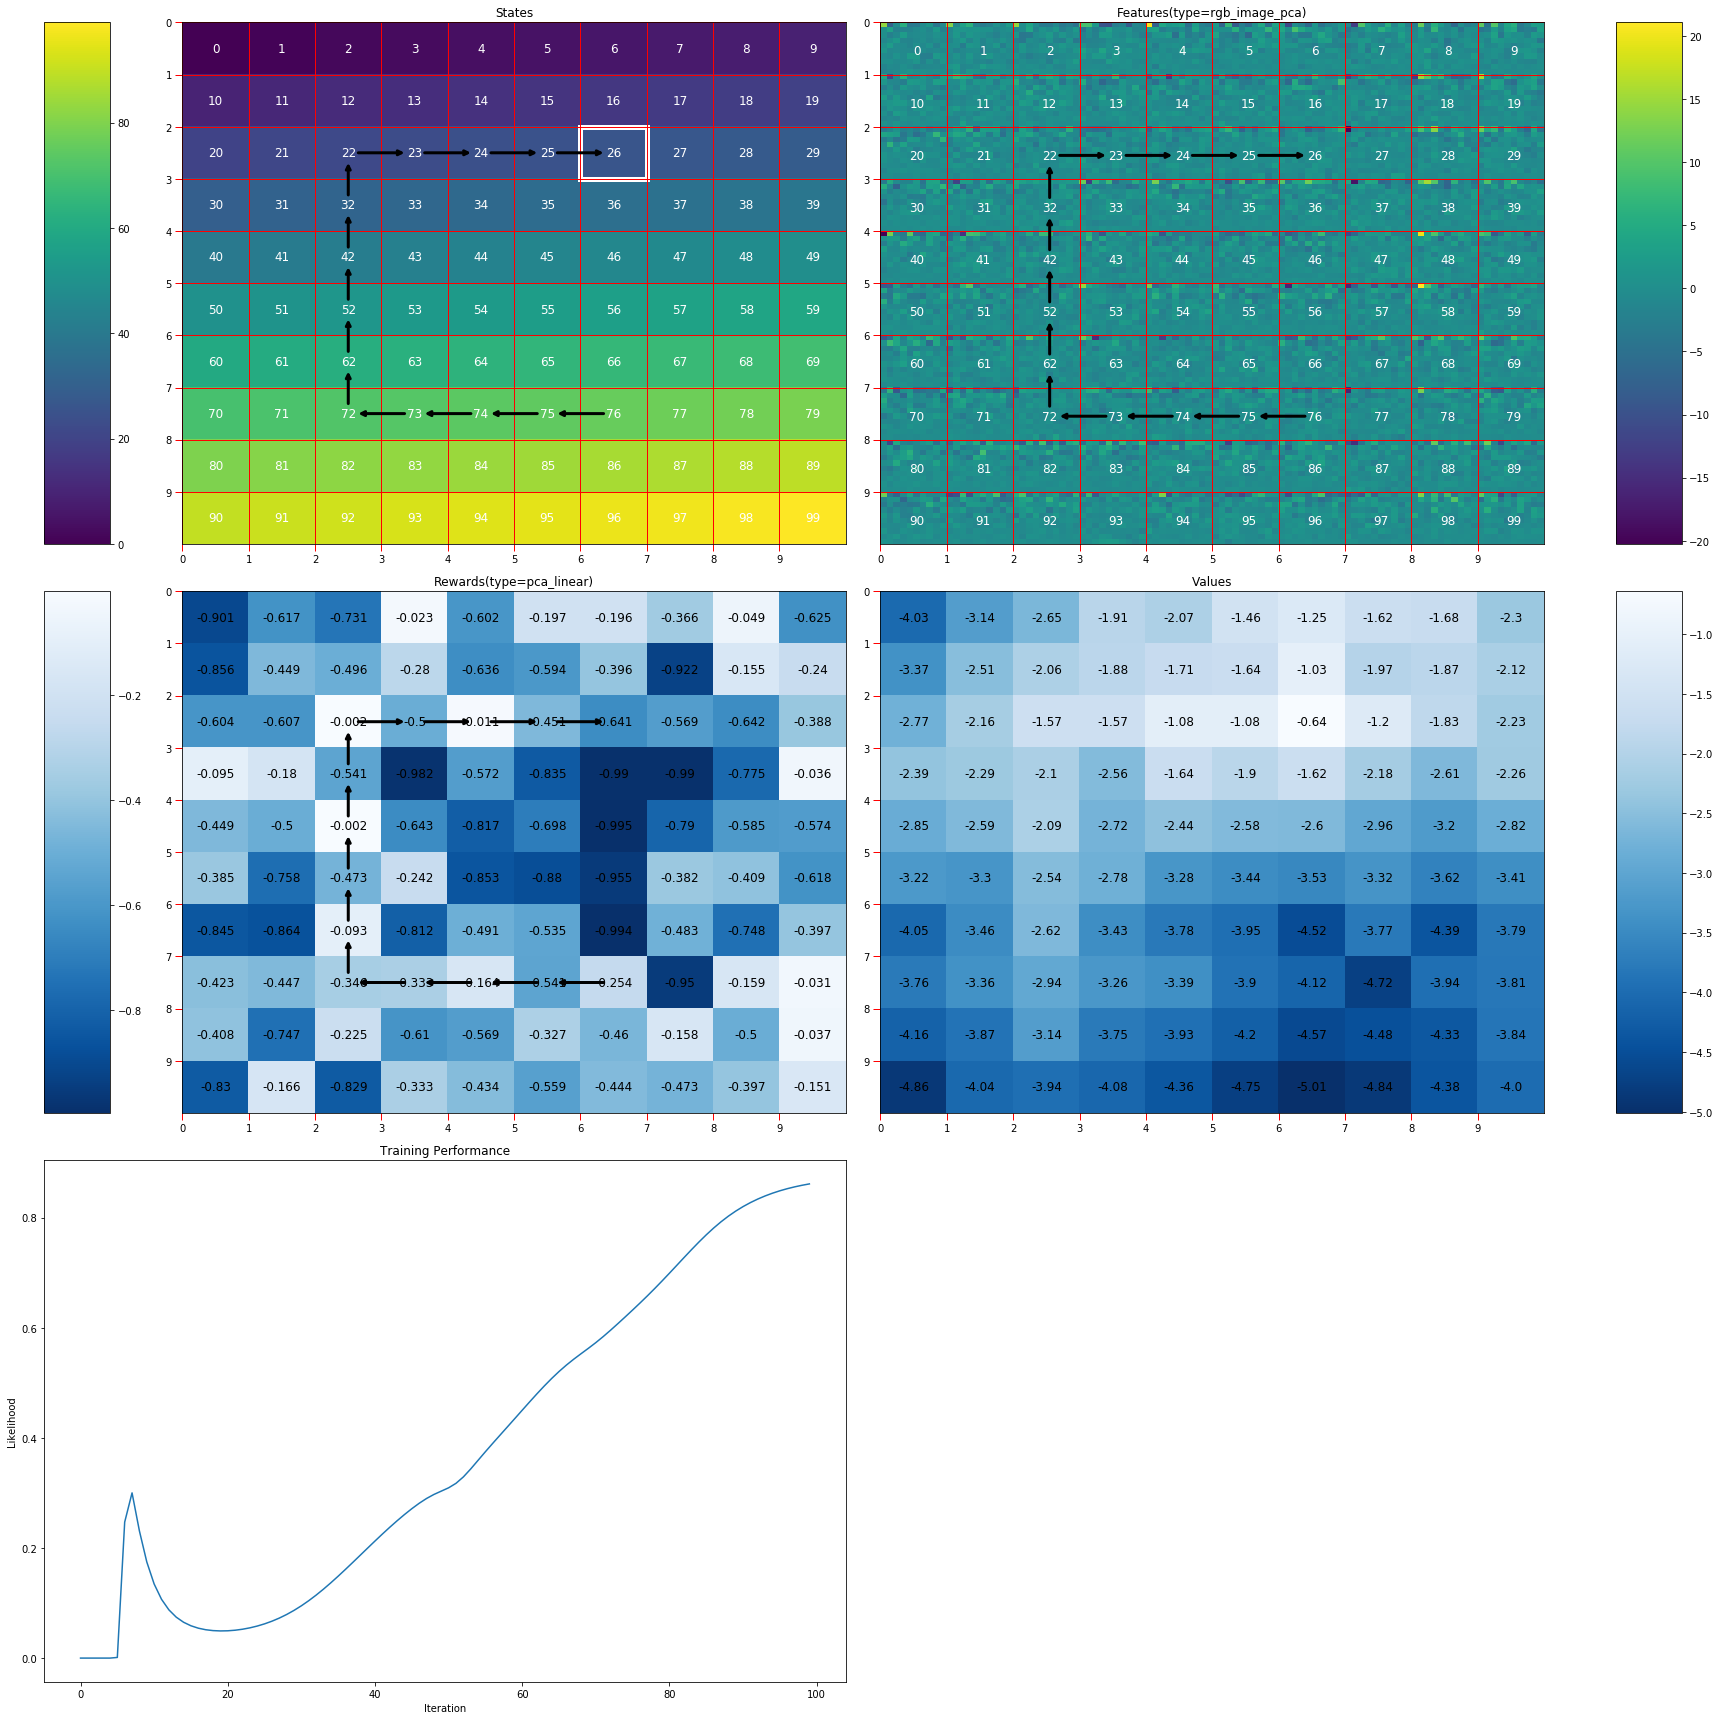

In [49]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="pca_linear", phi_key="rgb_image_pca")
plt.savefig("./figures/mlirl_gridworld_10x10_pca__traj_2_turns")

### Autonencoder + Linear

In [35]:
import os, os.path as osp
from rl.state_sampler import *
from navigation_vis.Raster import Raster as NavGridView

def ae_training_plot(x, x_recon, x_latent, loss_history, batch_size, title=""):
    
    grid_major_parms = {"linestyle": "-", "linewidth": "0.5", "color": "red"}
    cbar_pad = 1.0
    cbar_size = "10%"
    plt.subplot(221)
    NavGridView(lfdw.S._organize_to_grid(x.permute(0,2,3,1).detach())).ticks(minor=False).grid(
        major_parms=grid_major_parms).render(vmin=0., vmax=1.).title(
        "Input: Satellite Image RGB Tiles").colorbar(where="left", pad=cbar_pad, size=cbar_size)
    plt.subplot(222)
    NavGridView(lfdw.S._organize_to_grid(x_recon.permute(0,2,3,1).detach())).ticks(minor=False).grid(
        major_parms=grid_major_parms).render(vmin=0., vmax=1.).title(
        "Reconsruction").colorbar(where="left", pad=cbar_pad, size=cbar_size)
    plt.subplot(223)
    NavGridView(
        lfdw.S._organize_to_grid(
            x_latent.unsqueeze(-1).unsqueeze(-1).detach())).render().ticks(
        minor=False).grid(major_parms=grid_major_parms).render(vmin=-10., vmax=10.).title(
        "Latent Code").colorbar(where="left", pad=cbar_pad, size=cbar_size)
    if loss_history is not None:
        plt.subplot(224)
        plt.plot(loss_history)
        plt.title("Loss")
        plt.xlabel("x{} examples".format(batch_size))
        plt.ylim(0, np.max(loss_history))
    plt.suptitle(title)

convae_training__z_dim_0064__c1_016__cx1_004__fx1_004__lr_1.0000e-03__wd_1.0000e-06__batch_032
Pretrained weights loaded!


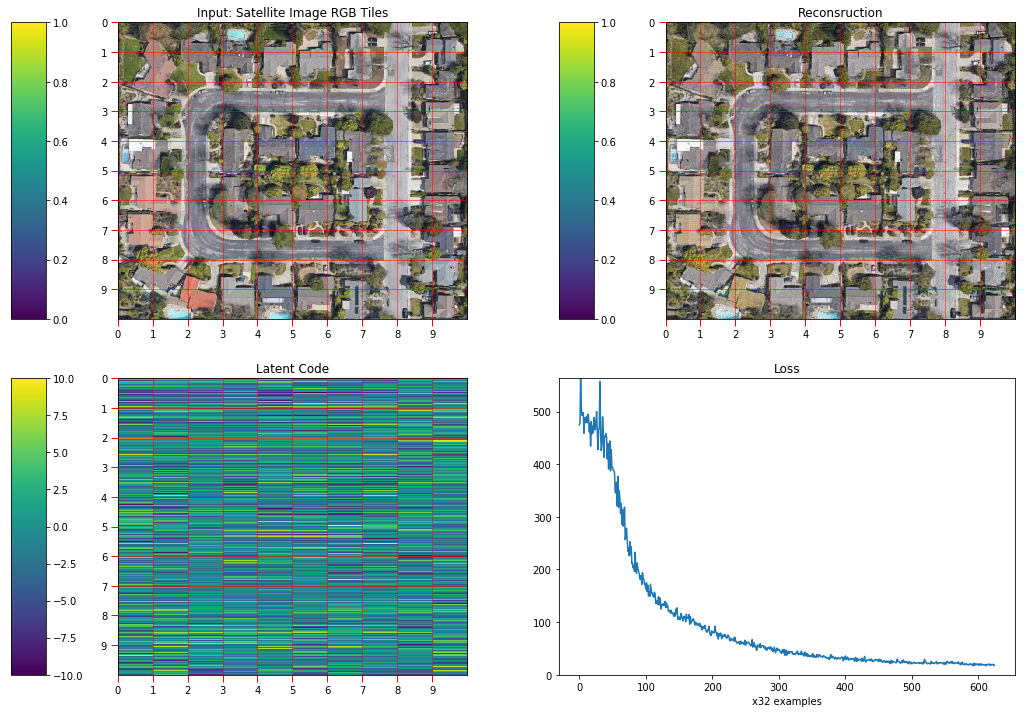

In [36]:
lr = 1e-3
wd = 1e-6
z_dim = 64
c1=16
cx1=4
fx1=4
batch_size = 32
# for lr in [1e-2, 1e-3, 1e-4]:
#     for z_dim in [16, 64, 256]:
#         for c1 in [4, 16, 64]:
ae_name = "convae_training__z_dim_{:04d}__c1_{:03d}__cx1_{:03d}__fx1_{:03d}__lr_{:.4e}__wd_{:.4e}__batch_{:03d}".format(
    z_dim, c1, cx1, fx1, lr, wd, batch_size)
print(ae_name)
store_dir = osp.join("./data/mlirl_gridworld_10x10_sat_img", ae_name)
os.makedirs(store_dir, exist_ok=True)

sat_img_sampler = StateSampler(lfdw.S, state_fn="get_features", 
                                       state_fn_args={"key": "rgb_image"},
                                       preprocess_fn=preprocess_fn, 
                                       batch_size=batch_size)
x_val = preprocess_fn(lfdw.features(numpyize=False, key="rgb_image"))
cvae = ConvFCAutoEncoder((3,60,80), z_dim=z_dim, lr=lr, weight_decay=wd, 
                         c1=c1, cx1=cx1, fx1=fx1,
                         store_dir=None, debug=False)
try:
    cvae.load(store_dir)
    print("Pretrained weights loaded!")
except:
    resp = input("Train? y/n")
    if resp in ["y", "Y"]:
        print("Training...")
        gif_maker = GifMaker(osp.join(store_dir, "{}.gif".format(ae_name)), fps=20, live_view=False)
        cvae.train(sat_img_sampler, epochs=200, plot_fn=ae_training_plot, gif_maker=gif_maker, x_val=x_val)
finally:
    plt.figure(figsize=(18,12))
    # plt.plot(cvae.loss_history)
    ae_training_plot(x_val, *cvae.forward(x_val, return_latent=True), cvae.loss_history, sat_img_sampler.batch_size)

In [37]:
x_, x_latent = cvae.forward(x_val, return_latent=True)
x_latent = x_latent.detach().numpy()

r_model_convae_linear = RewardLinear(x_latent.shape[1], lr=0.01, weight_decay=0.)
lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIdxToArray(lambda idx: x_latent[idx], key="convfc_ae"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model_convae_linear, preprocess_fn=preprocess_fn_linear,
        postprocess_fn=postprocess_fn_linear, 
        key="convfc_ae_linear", feature_key="convfc_ae"))

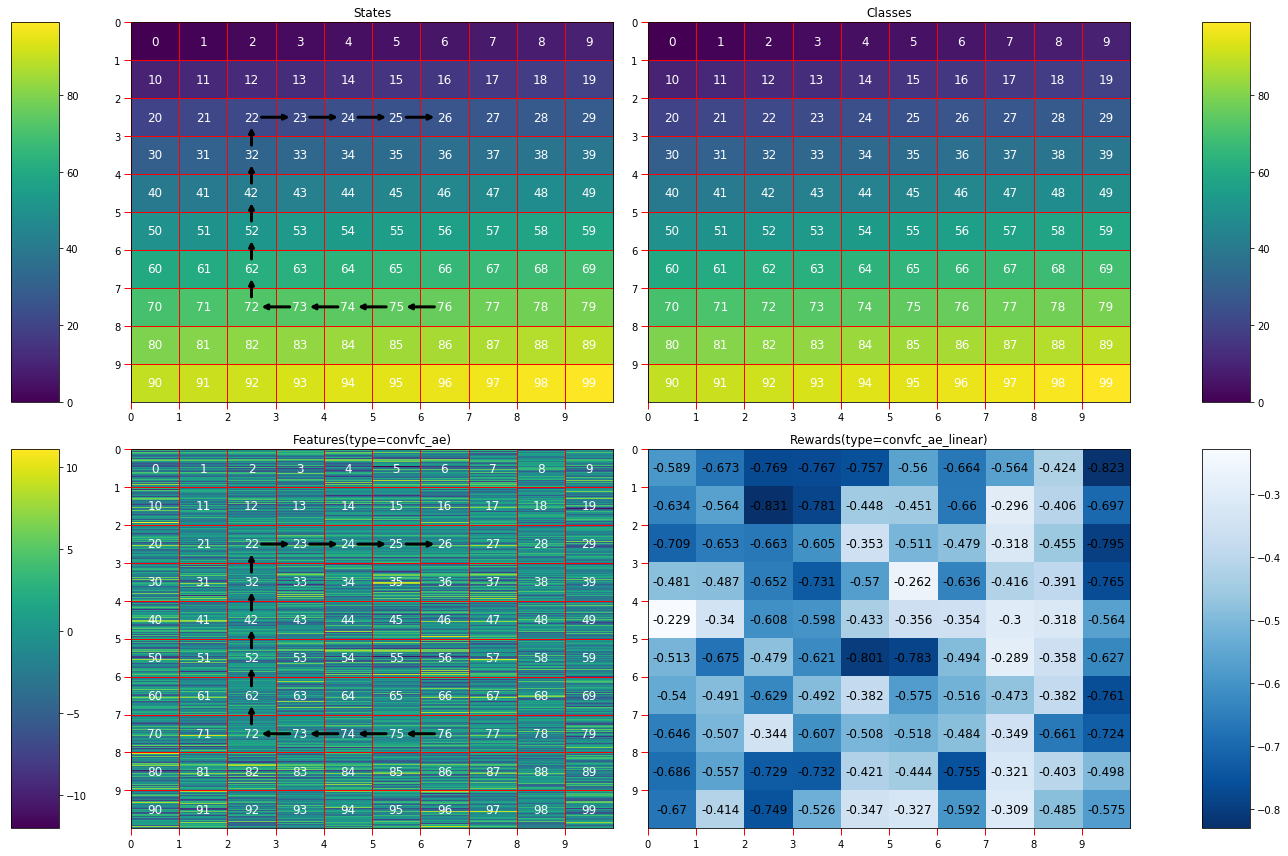

In [38]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="convfc_ae_linear", phi_key="convfc_ae")

In [40]:
train_mlirl = False

if train_mlirl:
    log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
        tau_lst = lfdw.trajectories(s_a_zipped=True),
        S = lfdw.S,
        PHI = preprocess_fn_linear(lfdw.features(numpyize=False, key="convfc_ae")),
        T = lfdw.dynamics(),
        R_model = r_model_convae_linear,
        gamma=0.99,
        mlirl_iters = 150,
        vi_max_iters = 250,
        reasoning_iters = 100,
        policy = lambda q: Policy.Boltzmann(q, boltzmann_temp=0.1),
        vi_eps=1e-4
    )
    
    VI = VI_by_goal[s_lst_lst[0][-1]]
    plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
                   VI.V.detach().numpy().round(2),
                   log_likelihoods_history, r_key="convfc_ae_linear", phi_key="convfc_ae")
    plt.savefig("./figures/mlirl_gridworld_10x10_convfc_ae__traj_2_turns")

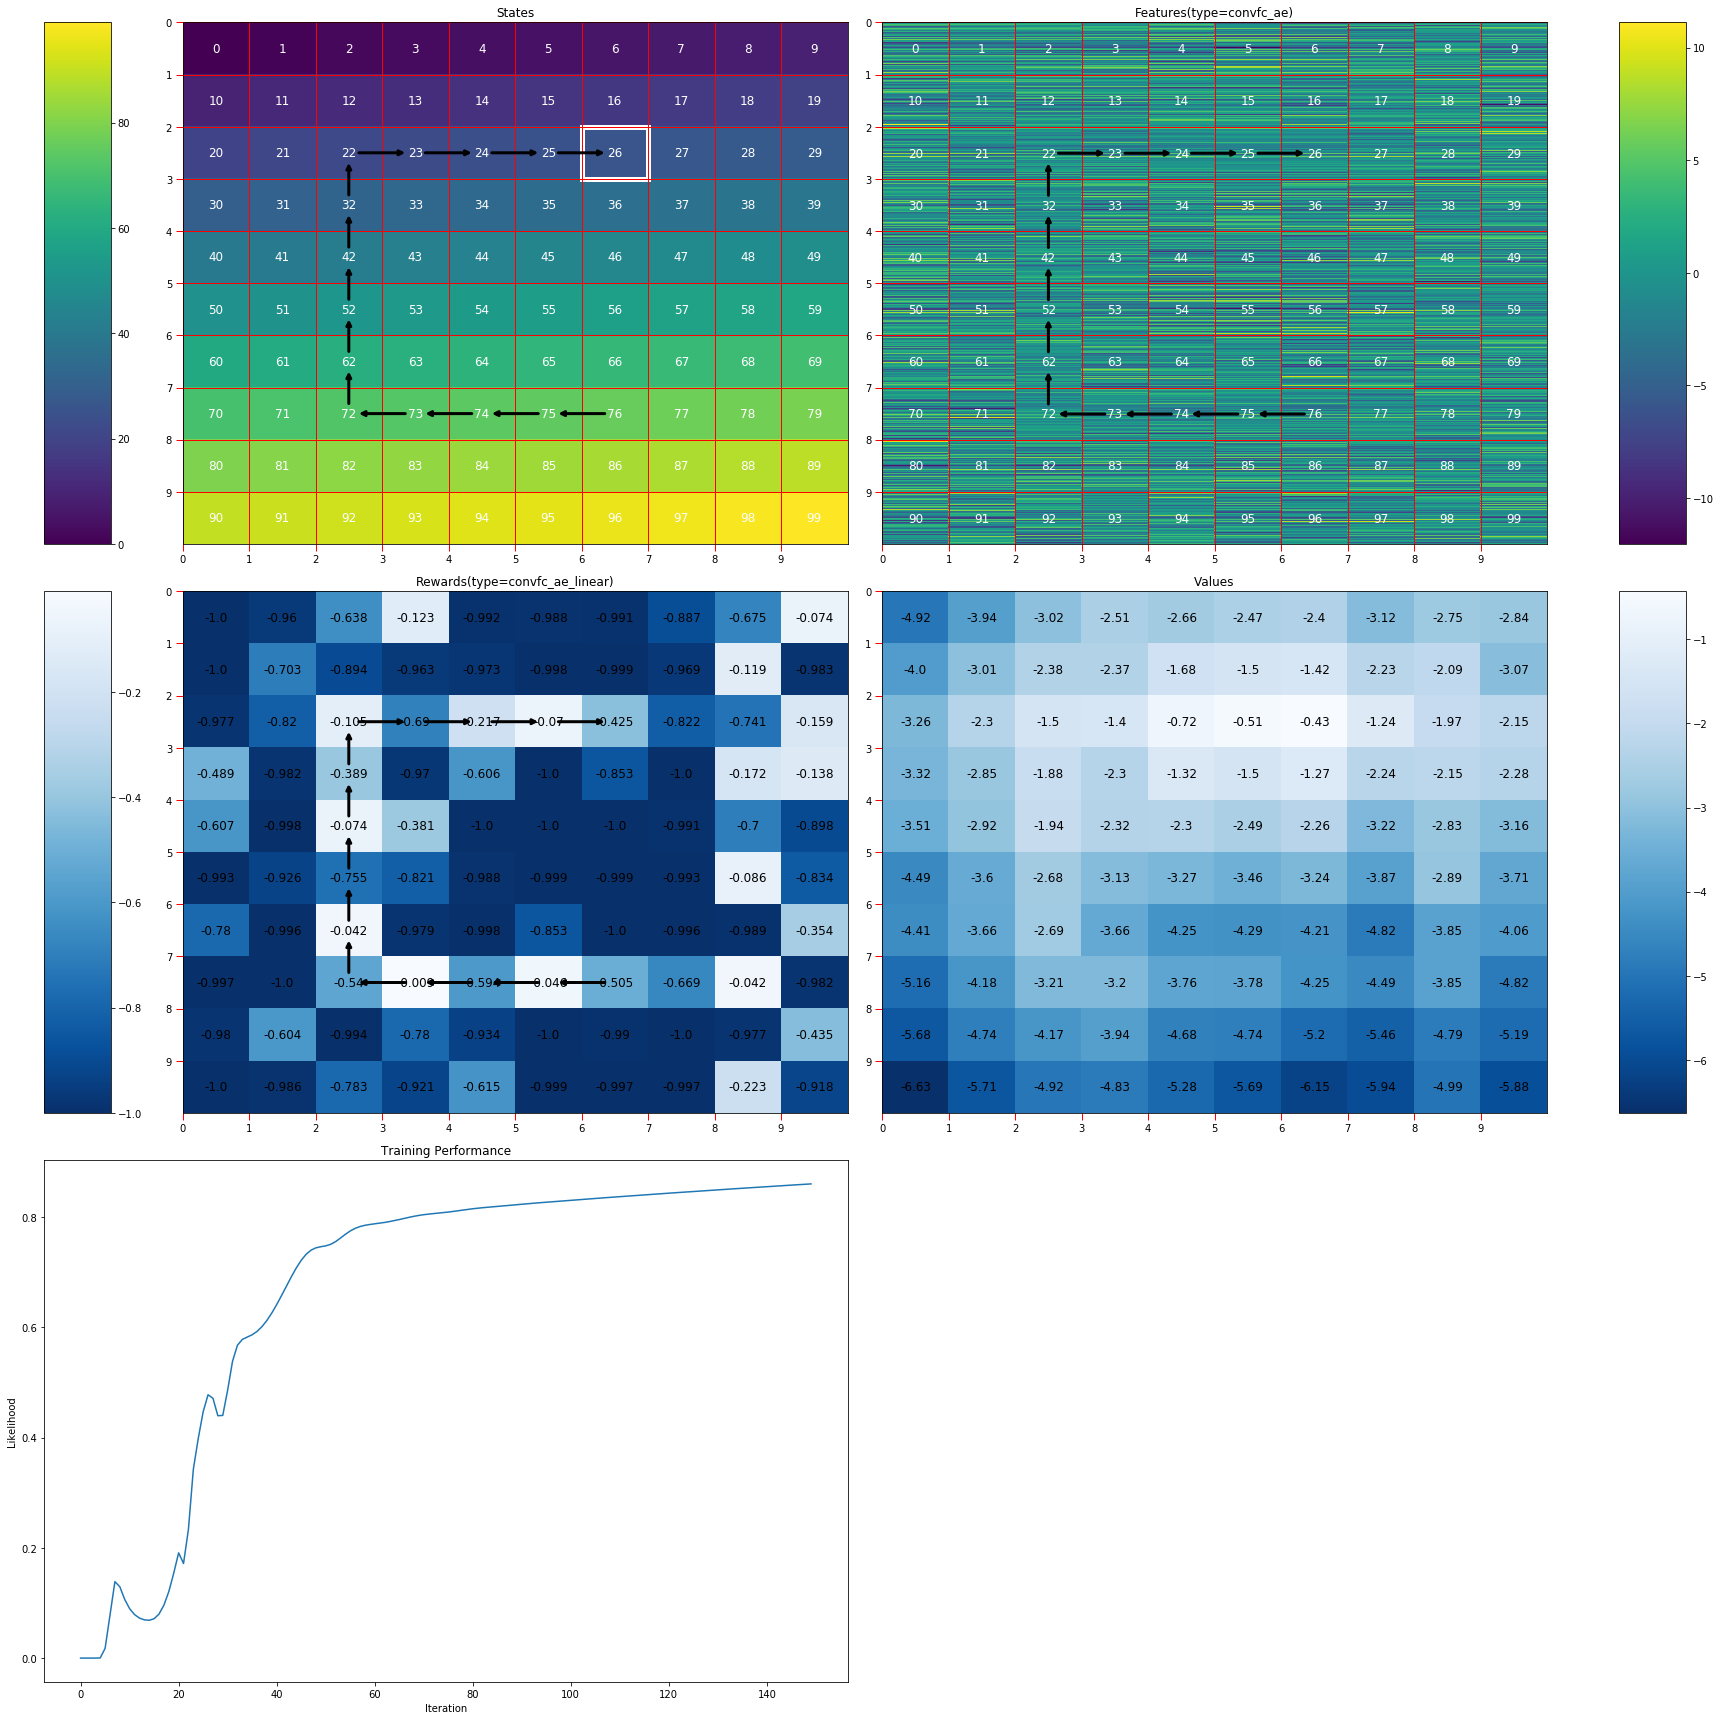

# TODO: 
- Multiple satellite images
- Draw path
- Joint inference

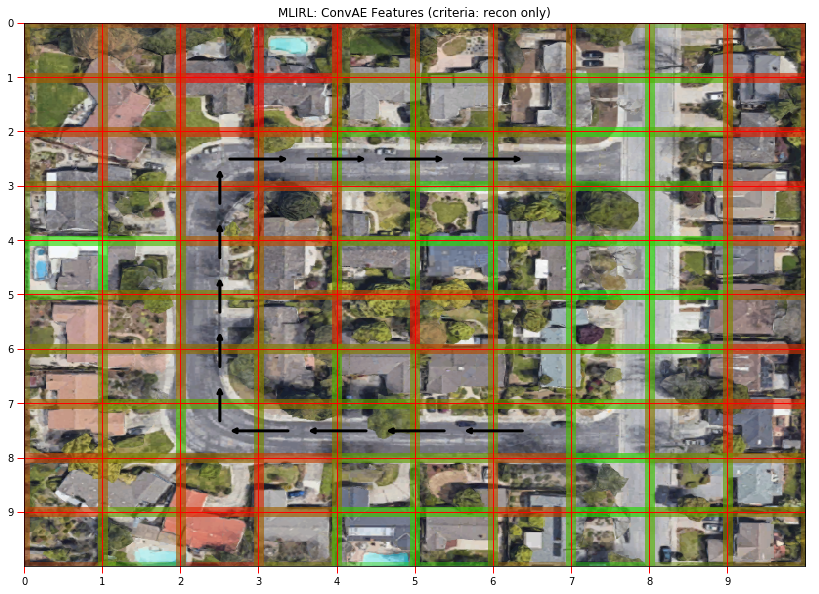

In [42]:
rs = lfdw.rewards(key="convfc_ae_linear")
rs = normalize(rs)

plt.figure(figsize=(14,10))
nv = NavGridView(lfdw.features(key="rgb_image")).render().ticks(minor=False).grid().add_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10}).highlight_cells(
    edgecolor=lambda idx: (1-rs[idx], rs[idx], 0), alpha=0.4).title(
    "MLIRL: ConvAE Features (criteria: recon only)")